In [10]:
from langgraph.graph.message import add_messages
from langchain_core.messages import ToolMessage, BaseMessage
from langgraph.graph import StateGraph, START, END
from typing import Annotated, TypedDict
from langchain_openai import ChatOpenAI
from langchain_community.tools import TavilySearchResults
from typing import Literal
import json
import os

In [11]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [12]:
# 工具节点
class BasicToolNode:
    def __init__(self, tools: list):
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # 获取消息列表中的最后一条消息，判断是否包含工具调用请求
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("输入中未找到消息")
        
        # 用于保存工具调用的结果
        outputs = []

        # 遍历工具调用请求，执行工具并将结果返回
        for tool_call in message.tool_calls:
            # 根据工具名称找到相应的工具，并调用工具的 invoke 方法执行工具
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            # 将工具调用结果作为 ToolMessage 保存下来
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),  # 工具调用的结果以 JSON 格式保存
                    name=tool_call["name"],  # 工具的名称
                    tool_call_id=tool_call["id"],  # 工具调用的唯一标识符
                )
            )
        # 返回包含工具调用结果的消息
        return {"messages": outputs}



In [13]:
def route_tools(state: State) -> Literal["tools", "__end__"]:
    """
    使用条件边来检查最后一条消息中是否有工具调用。
    
    参数:
    state: 状态字典或消息列表，用于存储当前对话的状态和消息。
    
    返回:
    如果最后一条消息包含工具调用，返回 "tools" 节点，表示需要执行工具调用；
    否则返回 "__end__"，表示直接结束流程。
    """
    # 检查状态是否是列表类型（即消息列表），取最后一条 AI 消息
    if isinstance(state, list):
        ai_message = state[-1]
    # 否则从状态字典中获取 "messages" 键，取最后一条消息
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    # 如果没有找到消息，则抛出异常
    else:
        raise ValueError(f"输入状态中未找到消息: {state}")

    # 检查最后一条消息是否有工具调用请求
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"  # 如果有工具调用请求，返回 "tools" 节点
    return END  # 否则返回 "__end__"，流程结束


In [14]:
# 开启 LangSmith 跟踪，便于调试和查看详细执行信息
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "ChatBotVoteWithSearch"

# Tavily 搜索工具
search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

# 创建聊天模型，并绑定工具
chat_model = ChatOpenAI(model="gpt-4o-mini").bind_tools(tools)

In [15]:
# 聊天节点
def chatbot(state: State):
    return {"messages": [chat_model.invoke(state["messages"])]}

In [16]:
def translate_to_chinese(input: State):
    content = input["messages"][-1].content
    return {"messages": [chat_model.invoke([
            ("system", "Translate the following text to Chinese: "),
            ("user", content),
            ]
    )]} 

In [17]:
def build_graph():
    # 工具节点
    tool_node = BasicToolNode(tools)

    graph_builder = StateGraph(State)

    # 添加节点
    graph_builder.add_node("chatbot", chatbot)
    graph_builder.add_node("tool_node", tool_node)
    graph_builder.add_node("traslate_node", translate_to_chinese)

    # 添加边
    graph_builder.add_edge(START, "chatbot")
    graph_builder.add_conditional_edges(
        "chatbot",
        route_tools,
        {
            "tools": "tool_node",
            END: "traslate_node",
        },
    )
    graph_builder.add_edge("tool_node", "chatbot")
    graph_builder.add_edge("traslate_node", END)

    return graph_builder.compile()


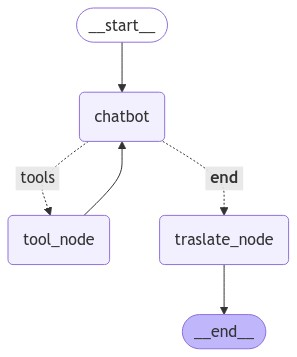

In [18]:
graph = build_graph()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass


In [19]:
# 选举问题。
vote_question = "Today is {current_date}, who was win the US presidential election on November 5, 2024?"

In [20]:
for event in graph.stream({"messages": [("user", vote_question)]}):
    for value in event.values():
        if isinstance(value["messages"][-1], BaseMessage):
            # 如果消息是 BaseMessage 类型，则打印机器人的回复
            last_msg = value["messages"][-1]
            if last_msg.content:
                print(f"Assistant: {last_msg.content}\n")
            else:
                print(f"Function: {last_msg.additional_kwargs['tool_calls']}\n")

Function: [{'id': 'call_RajCkFmbmJI9TiIxG6brpKTj', 'function': {'arguments': '{"query":"US presidential election results November 5, 2024"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]

Assistant: [{"url": "https://www.bbc.com/news/election/2024/us/results", "content": "US Presidential Election Results 2024 - BBC News Close menu BBC News Kamala Harris of the Democrat party has 0 electoral college votes. Donald Trump of the Republican party has 0 electoral college votes. Kamala Harris of the Democrat party has 158,810 votes (38.4%) Donald Trump of the Republican party has 249,225 votes (60.2%) US presidential election results 2024 US election 2024 Voting in some states is particularly hard to predict, with polls showing they could be won by the Republicans or the Democratic party. The battleground states that could decide the 2024 presidential election are: Voters in 11 states will also elect a governor. US election polls: Who is ahead - Harris or Trump? US election 202